In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical


2023-06-18 22:13:15.692881: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-18 22:13:15.739178: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-18 22:13:16.006816: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-18 22:13:16.008234: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-18 22:13:18.268799: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [28]:
# Load the dataset
dframe = pd.read_csv("/home/jovyan/work/data/health/filtered_full_relabel_i2b2.csv", encoding="ISO-8859-1")

def get_sentences(dataset):
    n_sent = 1
    grouped = dataset.groupby("sentence_idx").apply(lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(),
                                                                                      s["tag"].values.tolist())])
    sentences = [s for s in grouped]

    def get_next():
        nonlocal n_sent
        try:
            s = grouped["Sentence: {}".format(n_sent)]
            n_sent += 1
            return s
        except:
            return None

    return sentences, get_next

# Split the data into test and train sets
train_df, test_df = train_test_split(dframe, test_size=0.4)

train_df = train_df.sort_values(by='sentence_idx')
test_df = test_df.sort_values(by='sentence_idx')

train_df.to_csv("/home/jovyan/work/data/health/lstm/train.csv", index=False)
test_df.to_csv("/home/jovyan/work/data/health/lstm/test.csv", index=False)

# Get the sentences from the train set
train_sentences, _ = get_sentences(train_df)


# Get the maximum sequence length from the train sentences
maxlen = max([len(s) for s in train_sentences])
print('Maximum sequence length:', maxlen)

# Get the unique words and tags from the train set
words = list(set(train_df["word"].values))
words.append("ENDPAD")
tags = list(set(train_df["tag"].values))

words_full = list(set(dframe["word"].values))
words.append("ENDPAD")
tags_full = list(set(dframe["tag"].values))

# Create word and tag dictionaries
word2idx = {w: i for i, w in enumerate(words_full)}
word2idx["<OOV>"] = len(words_full)  # Add "<OOV>" with a new index value
tag2idx = {t: i for i, t in enumerate(tags_full)}



# Preprocess the train set
X_train = [[word2idx.get(w[0], word2idx["<OOV>"]) for w in s] for s in train_sentences]
X_train = pad_sequences(maxlen=maxlen, sequences=X_train, padding="post", value=len(words) - 1)
y_train = [[tag2idx[w[1]] for w in s] for s in train_sentences]
y_train = pad_sequences(maxlen=maxlen, sequences=y_train, padding="post", value=tag2idx["O"])
y_train = [to_categorical(i, num_classes=len(tags)) for i in y_train]

# Get the sentences from the test set
test_sentences, _ = get_sentences(test_df)

# Preprocess the test set
X_test = [[word2idx.get(w[0], word2idx["<OOV>"]) for w in s] for s in test_sentences]
X_test = pad_sequences(maxlen=maxlen, sequences=X_test, padding="post", value=len(words) - 1)
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]
y_test = pad_sequences(maxlen=maxlen, sequences=y_test, padding="post", value=tag2idx["O"])
y_test = [to_categorical(i, num_classes=len(tags)) for i in y_test]

n_words = len(words_full);
n_tags = len(tags_full);


number of train sentense:  11425
Maximum sequence length: 72
number of test sentense:  11332


In [12]:
from keras.models import Model
from tensorflow.keras.layers import Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

input = Input(shape=(maxlen,))
model = Embedding(input_dim=n_words, output_dim=maxlen, input_length=maxlen)(input)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer
input_t = Input(shape=(maxlen,))
model = Embedding(input_dim=n_words, output_dim=100, input_length=maxlen)(input_t)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer
model = Model(input_t, out)
from keras.losses import CategoricalCrossentropy

cross_entropy_loss = CategoricalCrossentropy()
model = Model(input_t, out)
model.compile(optimizer="adam", loss=cross_entropy_loss, metrics=["categorical_accuracy"])
history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=10, verbose=1)

Epoch 1/10
358/358 [==============================] - 40s 104ms/step - loss: 0.2358 - categorical_accuracy: 0.9653
Epoch 2/10
358/358 [==============================] - 38s 107ms/step - loss: 0.0936 - categorical_accuracy: 0.9735
Epoch 3/10
358/358 [==============================] - 39s 108ms/step - loss: 0.0686 - categorical_accuracy: 0.9807
Epoch 4/10
358/358 [==============================] - 39s 108ms/step - loss: 0.0524 - categorical_accuracy: 0.9852
Epoch 5/10
358/358 [==============================] - 39s 109ms/step - loss: 0.0401 - categorical_accuracy: 0.9884
Epoch 6/10
358/358 [==============================] - 38s 107ms/step - loss: 0.0316 - categorical_accuracy: 0.9906
Epoch 7/10
358/358 [==============================] - 38s 107ms/step - loss: 0.0258 - categorical_accuracy: 0.9923
Epoch 8/10
358/358 [==============================] - 39s 108ms/step - loss: 0.0216 - categorical_accuracy: 0.9934
Epoch 9/10
358/358 [==============================] - 38s 107ms/step - loss: 0.0

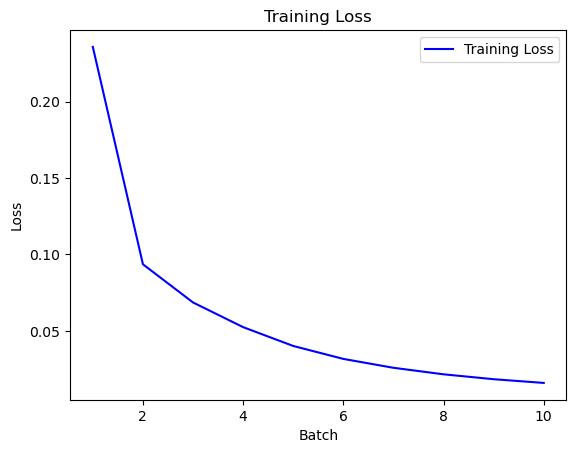

In [15]:
# Access the loss values and batch numbers from the history
loss_values = history.history['loss']
batches = range(1, len(loss_values) + 1)

# Plot the loss value over batches with a line
plt.plot(batches, loss_values, 'b-', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
y_pred = model.predict(X_test)
X_test.shape
y_pred_indices = np.argmax(y_pred, axis=-1)

y_pred_flattened = y_pred_indices.flatten()
y_true_indices = np.argmax(y_test, axis=-1)
y_true_flattened = y_true_indices.flatten()
precision_per_tag = {}
recall_per_tag = {}
f1_per_tag = {}
for tag, id in tag2idx.items():
    true_positives = np.sum((y_pred_flattened == id) & (y_true_flattened == id))
    false_positives = np.sum((y_pred_flattened == id) & (y_true_flattened != id))
    false_negatives = np.sum((y_pred_flattened != id) & (y_true_flattened == id))

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    precision_per_tag[tag] = round(precision, 2) * 100
    recall_per_tag[tag] = round(recall, 2) * 100
    f1_per_tag[tag] = round(f1_score, 2) * 100

from tabulate import tabulate

sorted_tags = sorted(tag2idx.items(), key=lambda x: x[0])

table_data = []
for tag, id in sorted_tags:
    row = [tag, precision_per_tag[tag], f1_per_tag[tag], recall_per_tag[tag]]
    table_data.append(row)

table_headers = ["Tag", "Precision", "F1 Score", "Recall"]
table = tabulate(table_data, headers=table_headers, tablefmt="plain", colalign=("left", "left", "left", "left"))

print(table)


354/354 [==============================] - 6s 18ms/step
Tag              Precision    F1 Score    Recall
B-AGE            71           71          71
B-HOSPITAL       86           75          67
B-MEDICALRECORD  87           65          51
B-ORGANIZATION   30           21          16
B-PER            72           66          62
B-PROFESSION     49           39          32
B-STATE          91           71          58
B-STREET         36           20          14
CITY             84           62          49
COUNTRY          33           12          8
DATE             89           79          71
EMAIL            0            0           0
FAX              0            0           0
I-AGE            0            0           0
I-HOSPITAL       80           76          73
I-MEDICALRECORD  55           45          38
I-ORGANIZATION   15           8           5
I-PER            62           49          41
I-PROFESSION     70           45          33
I-STATE          0            0           0
I

In [23]:
# Evaluation
loss, accuracy = model.evaluate(X_test, np.array(y_test))
print("Loss: {:.4f}".format(loss))
print("Accuracy: {:.2f}%".format(accuracy * 100))

354/354 [==============================] - 7s 18ms/step - loss: 0.0461 - categorical_accuracy: 0.9894
Loss: 0.0461
Accuracy: 98.94%


In [24]:
dir = "/home/jovyan/work/data/output/LSTM_health_b10_s4_b32"
model.save(dir)

2023-06-18 23:02:15.717386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'while/Placeholder_2' with dtype float and shape [?,100]
	 [[{{node while/Placeholder_2}}]]
2023-06-18 23:02:15.828899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'while/Placeholder_2' with dtype float and shape [?,100]
	 [[{{node while/Placeholder_2}}]]
2023-06-18 23:02:15.886513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and 

INFO:tensorflow:Assets written to: /home/jovyan/work/data/output/LSTM_health_b10_s4_b32/assets


INFO:tensorflow:Assets written to: /home/jovyan/work/data/output/LSTM_health_b10_s4_b32/assets


In [26]:
num_tags = train_df['tag'].value_counts()
print("Number of unique tags:", num_tags)


Number of unique tags: tag
O                  161651
DATE                11408
B-PER                4046
I-PER                3434
B-HOSPITAL           1274
I-HOSPITAL           1109
B-AGE                1074
I-MEDICALRECORD       880
PHONE                 758
B-MEDICALRECORD       587
IDNUM                 535
CITY                  484
I-STREET              404
B-STATE               252
B-PROFESSION          229
B-STREET              210
ZIP                   210
I-PROFESSION          192
USERNAME              129
B-ORGANIZATION        121
I-ORGANIZATION        111
COUNTRY                64
I-AGE                  36
FAX                    23
I-STATE                 8
EMAIL                   4
Name: count, dtype: int64
